In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import skimage.exposure
import pandas as pd

In [2]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD585'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
MASKED = os.path.join(DIR, 'preps', 'thumbnail_masked')
files = sorted(os.listdir(INPUT))

In [3]:
def linnorm(img, limit, dt):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    return img_norm.astype(dt)

def get_index(array, list_of_arrays):
    for j, a in enumerate(list_of_arrays):
        if np.array_equal(array, a):
            return j
    return None

In [4]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
masks = []
for i, file in enumerate(tqdm(files)):
    infile = os.path.join(INPUT, file)
    src = io.imread(infile)
    # for 16bit src = (src/256).astype('uint8')
    img_inputs.append(src)    
    file_inputs.append(file)
    
    start_bottom = src.shape[0] - 5
    bottom_rows = src[start_bottom:src.shape[0], :]
    avg = np.mean(bottom_rows)
    bgcolor = int(round(avg))
    lower = bgcolor - 8
    upper = bgcolor + 4
    bgmask = (src >= lower) & (src <= upper)
    
    src[bgmask] = bgcolor
    #src = linnorm(src, 240, src.dtype)
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(16,16))
    h_src = clahe.apply(src)
    start_bottom = h_src.shape[0] - 5
    bottom_rows = h_src[start_bottom:h_src.shape[0], :]
    avg = np.mean(bottom_rows)
    bgcolor = int(round(avg)) - 50
    
    
    h, im_th = cv2.threshold(h_src, bgcolor, 255, cv2.THRESH_BINARY_INV)
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    
    #####ret, threshed = cv2.threshold(h_src, bgcolor, 255, cv2.THRESH_BINARY_INV)
    #####threshed = np.uint8(threshed)
    #####connectivity = 4
    #####output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    #####labels = output[1]
    #####stats = output[2]
    #####row = find_main_blob(stats, h_src)
    #####blob_label = row[1]['blob_label']
    #####blob = np.uint8(labels == blob_label) * 255
    #####kernel10 = np.ones((10, 10), np.uint8)
    #####im_out = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    
    img_outputs.append(h_src)
    stencil = np.zeros(src.shape).astype('uint8')
    contours, hierarchy = cv2.findContours(im_out, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    totalarea = im_out.shape[0] * im_out.shape[1]
    
    lc = []
    c1 = max(contours, key = cv2.contourArea)
    lc.append(c1)
    area1 = cv2.contourArea(c1)
        
    area2 = 0
    idx = get_index(c1, contours)  # 2
    contours.pop(idx)
    if len(contours) > 0:
        c2 = max(contours, key = cv2.contourArea)
        area2 = cv2.contourArea(c2)
        if area2 > 610:
            lc.append(c2)
    cv2.fillPoly(stencil, lc, 255)
    
    if area1 > 3000:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        #(thresh, binRed) = cv2.threshold(stencil, 128, 255, cv2.THRESH_BINARY)
        opening = cv2.morphologyEx(stencil, cv2.MORPH_OPEN, kernel, iterations=3)
    else:
        opening = stencil
    
    masks.append(opening)
    titles.append((str(area1),str(area2), str(bgcolor), str(totalarea)))
    outpath = os.path.join(MASKED, file)
    cv2.imwrite(outpath, opening.astype('uint8'))


100%|██████████| 446/446 [00:09<00:00, 48.21it/s]


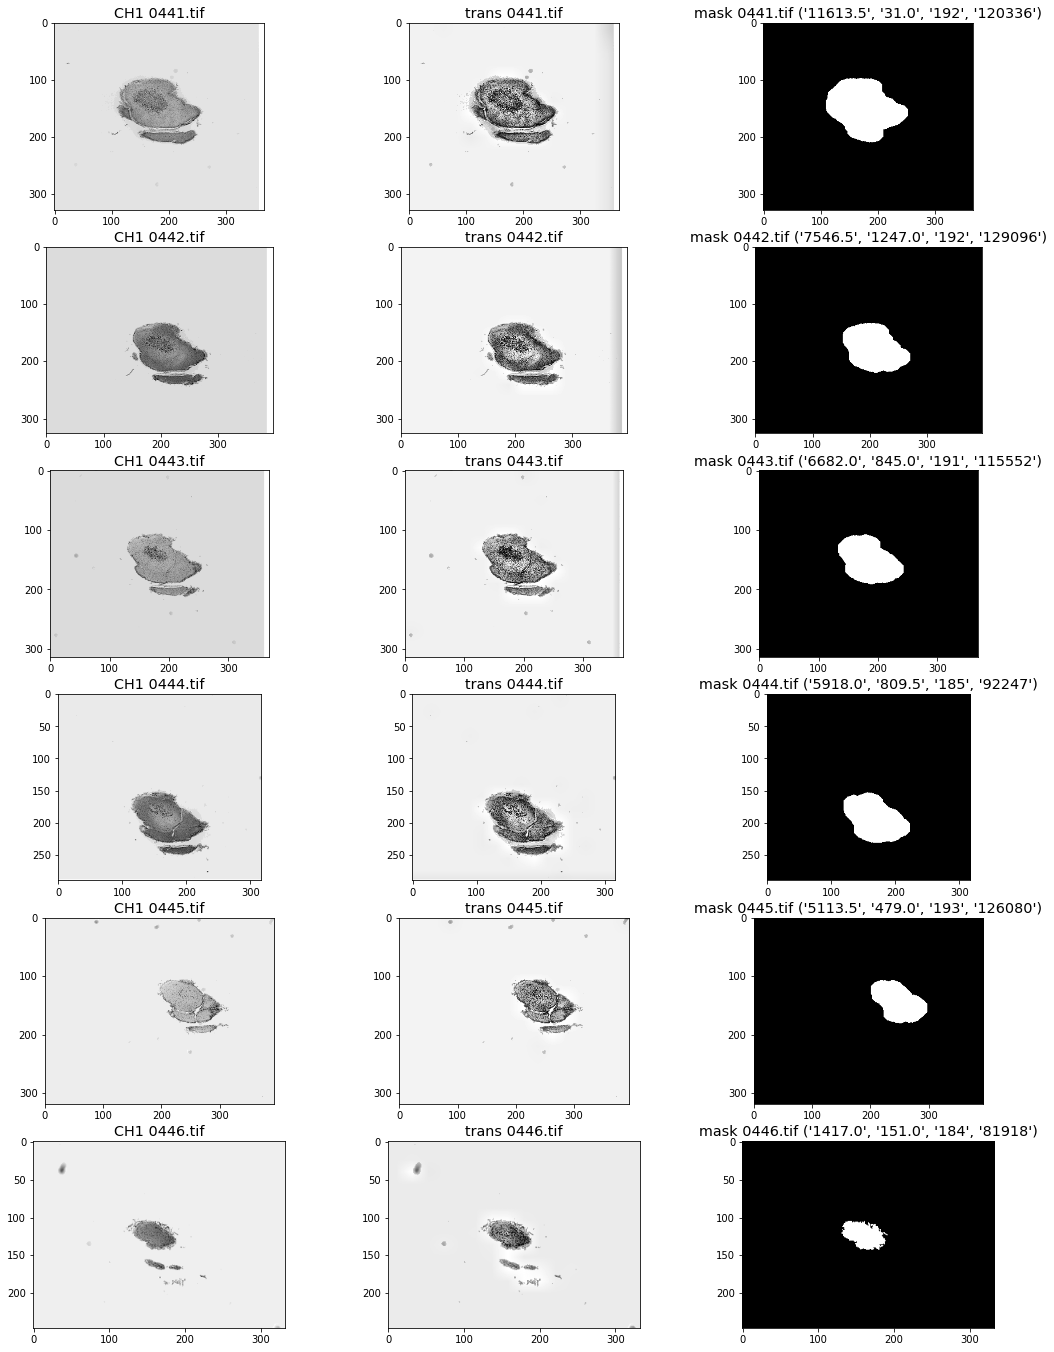

In [5]:
start, finish = (440,480)
#displays = masks[start:finish]
dins = img_inputs[start:finish]
douts = img_outputs[start:finish]
dmasks = masks[start:finish]
names = file_inputs[start:finish]
dtitles = titles[start:finish]

fig, ax = plt.subplots(nrows=len(names), ncols=3, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for filein,fileout, mask,name,title in zip(dins, douts, dmasks, names, dtitles):
    ax[i,0].set_title('CH1 {}'.format(name))
    ax[i,0].imshow(filein, cmap="gray")
    ax[i,1].set_title('trans {}'.format(name))
    ax[i,1].imshow(fileout, cmap="gray")
    ax[i,2].set_title('mask {} {}'.format(name, str(title)))
    ax[i,2].imshow(mask, cmap="gray")

    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=True)
plt.show()